# Predicting Churn

Classification trees with Titanic data file

This notebook has the following sections:

* [Data Loading and Description](#loading)
* [Classification Tree model](#CT)
* [Pruning the tree](#pruning)
* [Exploring the tree](#exploring)
* [Model performance](#performance)

In [22]:
!pip install pydotplus

In [23]:
import graphviz
import pydotplus


In [24]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

## Data Loading and Description <a id="loading" /> 

Variable description:

- **survived:	Survival (target variable) - 0 = No, 1 = Yes**
- pclass:	Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
- sex:	    Sex
- age:	    Age in years
- sibsp:	# of siblings / spouses aboard the Titanic
- parch:	# of parents / children aboard the Titanic
- ticket:	Ticket number
- fare:	    Passenger fare
- cabin:	Cabin number
- embarked:	Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton


Let's load the dataset and review null values

In [25]:
import openpyxl

# Red data
filename = 'Churn.xlsx'
df = pd.read_excel(filename, 0) #it has two sheets, we load the 2nd one
df.head()

,id,longdist,internat,local,int_disc,billtype,age,gender,marital,children,est_inco,car,pay_Bank,pay_CreditCard,pay_Cash,churn
0,1,27.09360,0.0,39.7357,0,1,35,1,1,0,77680.0,0,0,1,0,0
1,2,10.04270,0.0,46.3118,0,0,53,0,0,1,37111.5,1,1,0,0,0
2,3,23.76050,0.0,68.3512,1,1,65,1,1,1,37079.4,0,1,0,0,0
3,4,9.39559,0.0,13.9003,0,0,90,0,0,2,81997.0,0,0,0,1,0
4,5,14.15420,0.0,108.4330,1,0,39,1,0,0,16829.6,0,1,0,0,0


In [26]:
print ("Records and variables: ", df.shape)
print ("Column names: ", df.columns.to_list())

Records and variables:  (4431, 16)
Column names:  ['id', 'longdist', 'internat', 'local', 'int_disc', 'billtype', 'age', 'gender', 'marital', 'children', 'est_inco', 'car', 'pay_Bank', 'pay_CreditCard', 'pay_Cash', 'churn']


In [27]:
df.isnull().sum() #null values

id                0
longdist          0
internat          0
local             0
int_disc          0
billtype          0
age               0
gender            0
marital           0
children          0
est_inco          0
car               0
pay_Bank          0
pay_CreditCard    0
pay_Cash          0
churn             0
dtype: int64

4 variables with null values, mostly cabin and age. <BR>
We can discard cabin since it appears to be meaningless (and also ticket). <BR> 
We will need to delete records with missing values, otherwise the model will fail

In [28]:
#df['cabin'].unique() 

In [29]:
#droppping cabin and ticket
#df.drop(labels=['cabin', 'ticket'], axis=1, inplace=True)

Show % of records from each of the survived class

In [30]:
from collections import Counter

def class_perc(data):
    lendata = len(data)
    classes = Counter(data)
    
    for sclass, freq in classes.items():
        perc = (freq / lendata) * 100
        print(f"Churn '{sclass}': {perc:.2f}%")

class_perc(df['churn'])

Churn '0': 56.33%
Churn '1': 43.67%


In [31]:
df.isnull().sum()

id                0
longdist          0
internat          0
local             0
int_disc          0
billtype          0
age               0
gender            0
marital           0
children          0
est_inco          0
car               0
pay_Bank          0
pay_CreditCard    0
pay_Cash          0
churn             0
dtype: int64

Optionally, we delete missing values on age

In [32]:
#df=df.dropna(subset=['embarked', 'age', 'fare'])

## Classification Tree Model <a id="CT" /> 

Now we are going to split it into training and test (with same class distribution of survived variable in each set)

In [33]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = df.loc[:, dataframe.columns != 'churn']
    y = df['churn']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

X_train, X_test, Y_train, Y_test = split_df(df, seed=42, percentage=0.5)

In [34]:
print("Training data set: ", X_train.shape)
print("Testing data set: ", X_test.shape)
class_perc(Y_train.to_frame(name='churn')["churn"])
class_perc(Y_test.to_frame(name='churn')["churn"])

Training data set:  (2215, 15)
Testing data set:  (2216, 15)
Churn '1': 43.66%
Churn '0': 56.34%
Churn '1': 43.68%
Churn '0': 56.32%


In [35]:
from sklearn.tree import DecisionTreeClassifier

churn_tree = DecisionTreeClassifier(random_state=42, criterion="entropy")
churn_tree.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Let's take a look to the performance of the classifier (by initially using Accuracy)

In [36]:
from sklearn.metrics import mean_squared_error
predtrain= churn_tree.predict(X_train)
predictions = churn_tree.predict(X_test)
print("Accuracy of Train set = {0:.2%}".format(accuracy_score(Y_train, predtrain)))
print("Accuracy of Test set = {0:.2%}".format(accuracy_score(Y_test, predictions)))

Accuracy of Train set = 100.00%
Accuracy of Test set = 93.55%


Now we will take a look to the tree itself. This is a bit complex since sklearn does not provide a way to visualize the models. To that end, we will need to make use of an external library: `pydotplus`.

In [37]:
import os

graphviz_path = "C:/Program Files/Graphviz/bin"  #Replace with your Graphviz installation path
os.environ["PATH"] += os.pathsep + graphviz_path


In [59]:
#! pip install pydotplus

# you need to install this library directly from https://graphviz.org/download/ 
# and then add graphviz to the Path, uncommenting the following two lines and change instalattion folder

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

# DOT data
dot_data = export_graphviz(churn_tree, out_file=None, 
                                class_names=["0","1"],
                                feature_names=X_train.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render(filename="OriginalTree", format="png", view=True)

'OriginalTree.png'

In [60]:
# How many nodes and leaves?
print("Number of nodes: ", churn_tree.tree_.node_count)
print("Number of leaves: ", churn_tree.get_n_leaves())

Number of nodes:  325
Number of leaves:  163


We will plot the feature importance

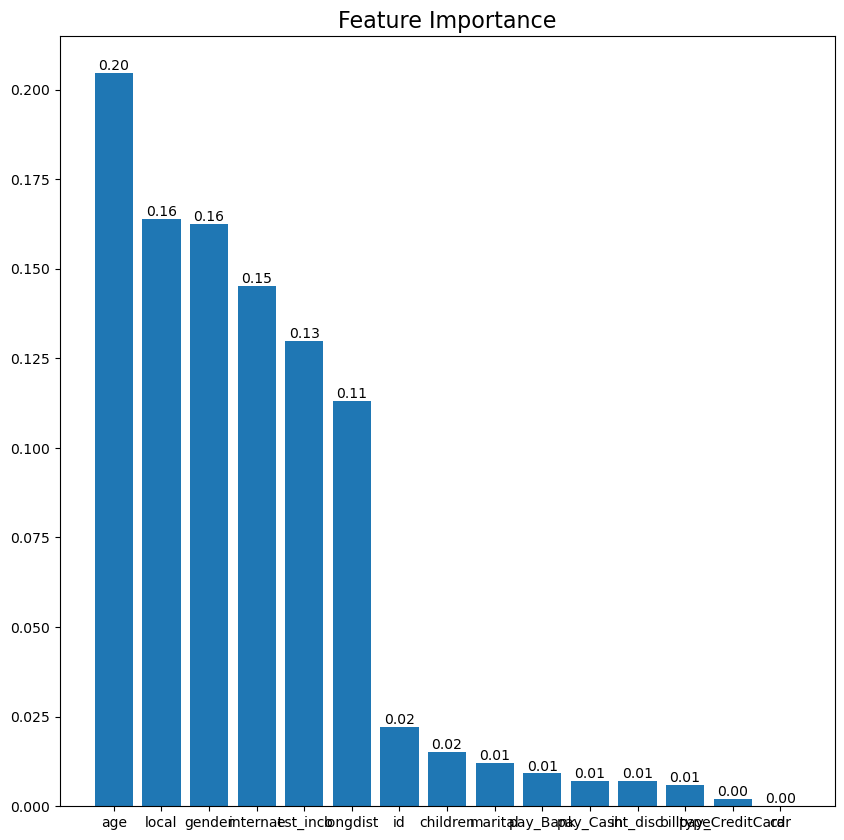

In [61]:
dfsorted =pd.DataFrame(churn_tree.feature_importances_, X_train.columns)
dfsorted=dfsorted.sort_values([0])[::-1]

plt.figure(figsize=(10,10))
plt.bar(dfsorted.index, dfsorted[0])
for i, value in enumerate(dfsorted[0]):
    plt.text(i, value, f'{value:.2f}', ha="center", va="bottom")
plt.title('Feature Importance', fontsize=16);

## Pruning the tree: avoiding overfitting <a id="pruning" /> 

Now we will prune the tree to see if we can improve performance.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to 30, 100, 300, etc or 5% of total 
 - min_samlples_split: Sets the minimum number of samples required to split an internal node
 - max_features: Limits the number of features considered for splitting at each node
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to 3, 5, 10 depending after verification on test data

Let's focus on the depth of the tree. We will test different depth thresholds via CV by using the `GridSearchCV` provided by sklearn.

In [97]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1,16)} # 15 different depth levels

churn_tree_pruned_cv = GridSearchCV(churn_tree, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

churn_tree_pruned_cv.fit(X_train,Y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [89]:
print("Best parameters set found on development set:")
print()
print(churn_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = churn_tree_pruned_cv.cv_results_['mean_test_score']
stds = churn_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, churn_tree_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 15}

Grid scores on development set:

Accuracy = 0.727 (+/0.098) for {'max_depth': 1}
Accuracy = 0.801 (+/0.081) for {'max_depth': 2}
Accuracy = 0.837 (+/0.061) for {'max_depth': 3}
Accuracy = 0.841 (+/0.056) for {'max_depth': 4}
Accuracy = 0.849 (+/0.063) for {'max_depth': 5}
Accuracy = 0.862 (+/0.073) for {'max_depth': 6}
Accuracy = 0.866 (+/0.076) for {'max_depth': 7}
Accuracy = 0.871 (+/0.073) for {'max_depth': 8}
Accuracy = 0.874 (+/0.074) for {'max_depth': 9}
Accuracy = 0.893 (+/0.057) for {'max_depth': 10}
Accuracy = 0.893 (+/0.055) for {'max_depth': 11}
Accuracy = 0.904 (+/0.058) for {'max_depth': 12}
Accuracy = 0.908 (+/0.057) for {'max_depth': 13}
Accuracy = 0.911 (+/0.066) for {'max_depth': 14}
Accuracy = 0.914 (+/0.061) for {'max_depth': 15}


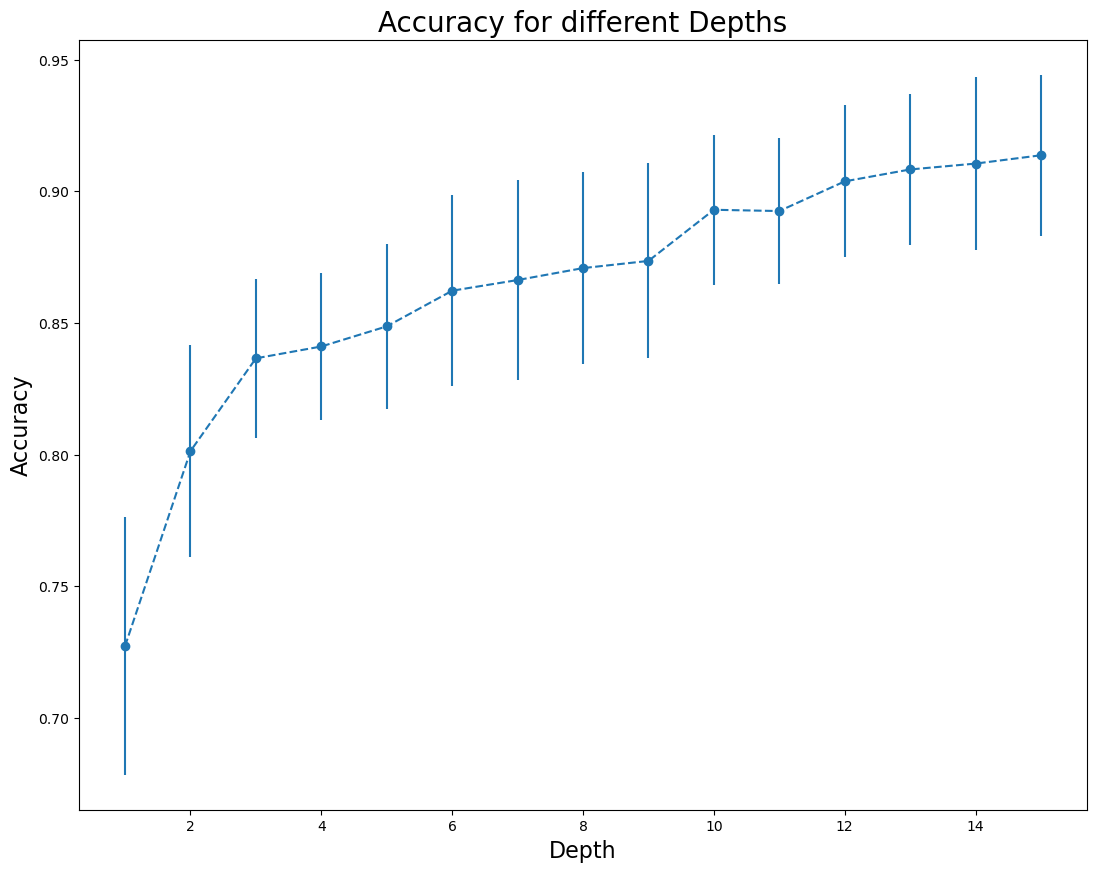

In [90]:
plt.figure(figsize=(13,10))
plt.errorbar(range(1,16,1), [m for m in means], yerr=stds, fmt='--o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

As can be seen in the plot, the optimal value for the depth of the decision tree is 3.

In [91]:
churn_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=3, criterion="entropy")
tree=churn_tree_pruned.fit(X_train, Y_train)
predtrain=churn_tree_pruned.predict(X_train)
predictions = churn_tree_pruned.predict(X_test)
print("Accuracy of Train set = {0:.2%}".format(accuracy_score(Y_train, predtrain)))
print("Accuracy of Test set = {0:.2%}".format(accuracy_score(Y_test, predictions)))

Accuracy of Train set = 83.79%
Accuracy of Test set = 84.79%


Great! We have increase the accuracy of Test set with a smaller tree.<BR>
Let's plot Precision vs. Recall curve

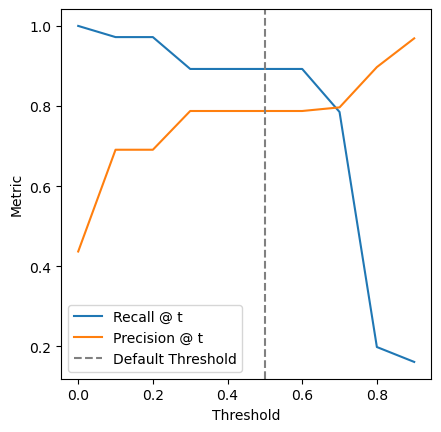

In [92]:
from sklearn.metrics import recall_score, precision_score
prob_pred = tree.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.1)
recall_scores = [metrics.recall_score(Y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(Y_test, prob_pred > t) for t in thresholds]
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric")
ax.set_box_aspect(1)
ax.legend()
plt.show()

How many nodes and leaves has the pruned tree?

In [93]:
print("Number of nodes: ", churn_tree_pruned.tree_.node_count)
print("Number of leaves: ", churn_tree_pruned.get_n_leaves())

Number of nodes:  15
Number of leaves:  8


And we can produce the list of rules that the tree has implemented

In [94]:
from sklearn import tree

text_representation = tree.export_text(churn_tree_pruned)
print(text_representation)
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_7 <= 0.50
|   |--- feature_3 <= 5.01
|   |   |--- feature_6 <= 57.50
|   |   |   |--- class: 1
|   |   |--- feature_6 >  57.50
|   |   |   |--- class: 1
|   |--- feature_3 >  5.01
|   |   |--- feature_2 <= 1.02
|   |   |   |--- class: 0
|   |   |--- feature_2 >  1.02
|   |   |   |--- class: 1
|--- feature_7 >  0.50
|   |--- feature_6 <= 39.50
|   |   |--- feature_1 <= 1.73
|   |   |   |--- class: 1
|   |   |--- feature_1 >  1.73
|   |   |   |--- class: 0
|   |--- feature_6 >  39.50
|   |   |--- feature_1 <= 0.80
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.80
|   |   |   |--- class: 1



## Exploring the tree <a id="exploring" /> 

We are now going to deep down a bit more on the tree.<BR>


In [95]:
# DOT data
dot_data = export_graphviz(churn_tree_pruned, out_file=None, 
                                class_names=["No","Yes"],
                                feature_names=X_train.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render(filename="Pruned Tree", format="png", view=True)

'Pruned Tree.png'

Another option:
we need to install the powerful library *dtreeviz* for this

/Users/alvaroserrano/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


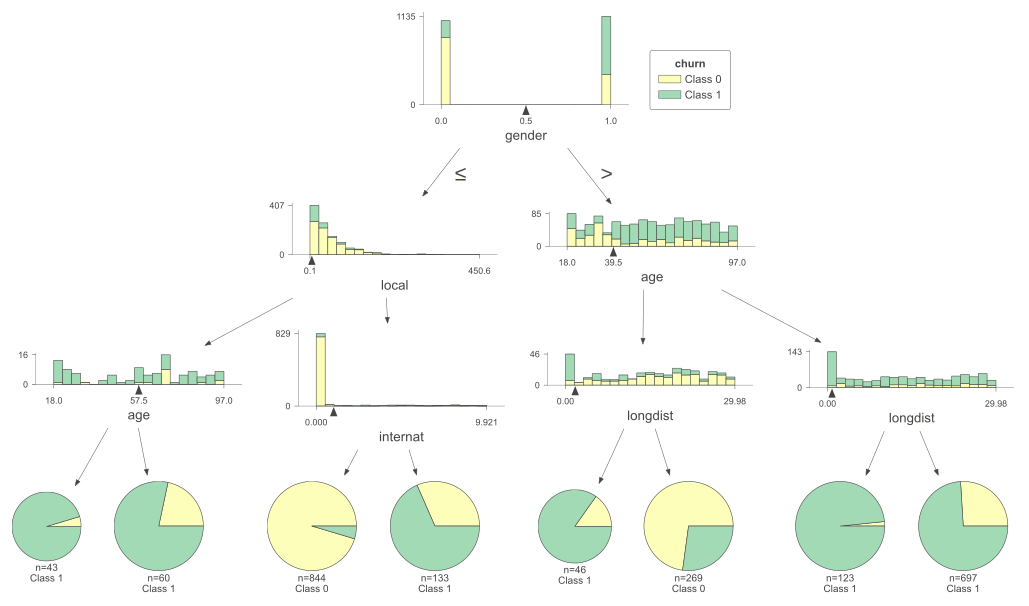

In [96]:
import dtreeviz

viz_cmodel = dtreeviz.model(churn_tree_pruned,
                           X_train=X_train,
                           y_train=Y_train,
                           feature_names=X_train.columns,
                           target_name='churn')
viz_cmodel.view(scale=1.5)

Display now frequencies for each node.<BR>
We can see node id=6 is the one with maximum amount of people

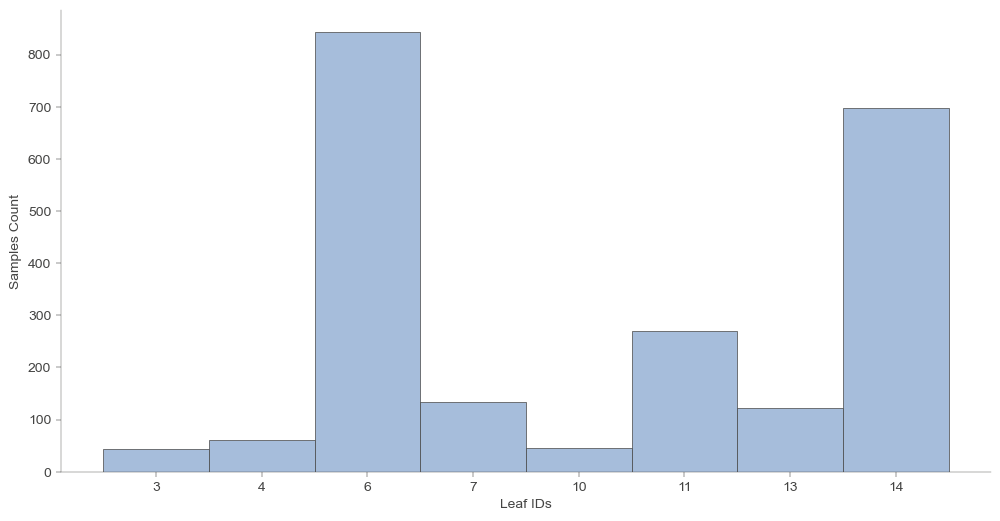

In [71]:
viz_cmodel.leaf_sizes(figsize=(12,6))

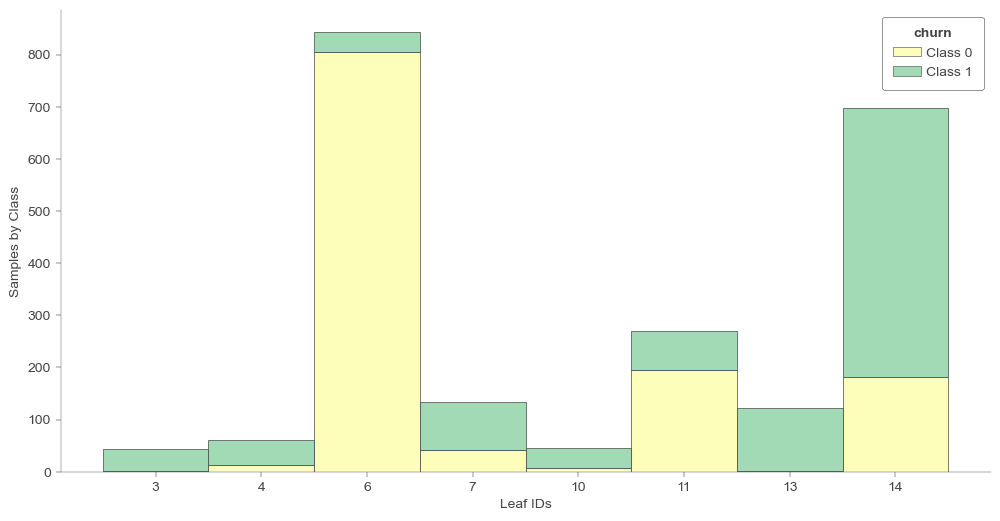

In [72]:
# Compare them now with target classes
viz_cmodel.ctree_leaf_distributions(figsize=(12,6))

Let's explore that node, id=6

In [73]:
viz_cmodel.node_stats(node_id=6)

,id,longdist,internat,local,int_disc,billtype,age,gender,marital,children,est_inco,car,pay_Bank,pay_CreditCard,pay_Cash
count,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0,844.0
mean,2155.421801,15.244357,0.018794,53.840943,0.310427,0.504739,58.125592,0.0,0.594787,1.00237,48415.672802,0.325829,0.196682,0.585308,0.218009
std,1244.662763,8.292305,0.110356,50.167949,0.462943,0.500274,22.810912,0.0,0.491224,0.843646,28151.602772,0.468962,0.397726,0.492961,0.413139
min,10.0,0.031102,0.0,5.04868,0.0,0.0,18.0,0.0,0.0,0.0,110.284,0.0,0.0,0.0,0.0
25%,1049.25,8.15963,0.0,19.19,0.0,0.0,39.0,0.0,0.0,0.0,24340.425,0.0,0.0,0.0,0.0
50%,2151.5,15.1936,0.0,38.2501,0.0,1.0,58.0,0.0,1.0,1.0,48798.1,0.0,0.0,1.0,0.0
75%,3237.5,22.5139,0.0,72.1049,1.0,1.0,78.0,0.0,1.0,2.0,70791.85,1.0,0.0,1.0,0.0
max,4431.0,29.9482,0.985628,332.464,1.0,1.0,97.0,0.0,1.0,2.0,99619.9,1.0,1.0,1.0,1.0


## Model performance <a id="performance" /> 

Finally, let's going to analyze model performance (on test data set)

In [74]:
# Function to print Confusion Matrix and Classification Report
# df_cm, df_perf = model_perf(titanic_tree_pruned, Y_test, predictions, "Classification Tree", df_cm, df_perf, plot = True)
def model_perf(model, Y_test, Y_predict, algorithm, df_cm, df_perf, ax=None, plot = True):
    # confusion_matrix
    conf_mat = confusion_matrix(Y_test, Y_predict)
    
    # get accuracy of model
    acc_score = accuracy_score(Y_test, Y_predict)
    print(f"Accuracy of {algorithm} for Test data is {acc_score*100}\n")

    # get F1-score of model
    f1score = f1_score(Y_test, Y_predict) 
    print(f"F1-score of {algorithm} for Test data is {f1score*100}\n")
    
    # get the classification report
    class_report = classification_report(Y_test, Y_predict)
    print(f"Classification report for {algorithm} is: \n {class_report}")
    
    # AUC Calculations - false positive rates, true positive rates and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_predict, pos_label=1)
    
    #area_under_curve
    roc_auc = round(metrics.auc(fpr, tpr)*100,2)
    print(f"AUC for {algorithm}: {roc_auc}\n")
    
    #Train Accuracy score
    train_acc = round(model.score(X_train,Y_train) * 100,2)

    #Test Accuracy score
    test_acc = round(model.score(X_test,Y_test) * 100,2)

    precision,recall,fscore,support = precision_recall_fscore_support(Y_test,Y_predict)

    #Appending into the dataframe
    newrow_perf= pd.DataFrame({'Model' : [algorithm],'Train Accuracy' : [train_acc],'Test Accuracy' : [test_acc],
                          'F1-Score' : [fscore[1]],'Recall' : [recall[1]], 'Precision' : [precision[1]], 'AUC' : [roc_auc]})
    
    df_perf = pd.concat([df_perf, newrow_perf], ignore_index=True)

    
    newrow_cm= pd.DataFrame({"Model" : [algorithm], "True Positives" : [conf_mat[1][1]], "True Negatives" : [conf_mat[0][0]],
                             "False Positives" : [conf_mat[0][1]], "False Negatives" : [conf_mat[1][0]]})
                            
    df_cm = pd.concat([df_cm, newrow_cm], ignore_index=True, sort=False)

##########################################--PLOT---###########################################
    if plot:
        def conf_plot1(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            # For label annotations in confusion_matrix
            label_names = ['True N','False N','False P','True P']
            label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
            labels = np.asarray(labels).reshape(2,2)

            # Draw heatmap using confusion matrix
            sns.heatmap(conf_mat, annot=labels, fmt='')
            ax.set_xlabel('Actual Values')
            ax.set_ylabel('Predicted Values')
            #ax.show()

        #Line plot for ROC curve using fpr and tpr value
        def roc_plot2(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            ax.plot(fpr, tpr, color='red', label = 'AUC = %0.3f' % roc_auc)  
            ax.set_title('Receiver Operating Characteristic (ROC)')    
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],linestyle='--') #Intersection line
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_xticks([i for i in np.arange(0,1.1,0.1)])
            ax.set_yticks([i for i in np.arange(0,1.1,0.1)])
        
        prec, rec, thres = precision_recall_curve(Y_test, Y_predict)
        prec, rec, thres = prec.tolist(), rec.tolist(), thres.tolist()
        prec.pop()
        rec.pop()
            
        def rec_plot3(ax = None):
            if ax is None:
                fig, ax = plt.subplots()
            #Plot Precision-Recall curve
            fig, axis = (None, ax) if ax else plt.subplots()
            axis_twin = axis.twinx()

            #Threshold vs Precision
            sns.lineplot(x = thres, y = prec, label='Precision', ax=axis)
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Precision')
            axis.legend(loc='lower left')

            #Threshold vs Recall
            sns.lineplot(x = thres, y = rec, color='limegreen', label='Recall', ax=axis_twin)
            axis_twin.set_ylabel('Recall')
            axis_twin.set_ylim(0, 1)
            axis_twin.legend(bbox_to_anchor=(0.32, 0.20),loc='lower right')

            axis.set_xlim(0, 1)
            axis.set_ylim(0, 1)
            axis.set_title('Precision Vs Recall')
        
                    
        fig = plt.figure(figsize = (15,4))
        ax1 = fig.add_subplot(1,3,1)
        conf_plot1(ax1)
        ax2 = fig.add_subplot(1,3,2)
        roc_plot2(ax2)
        axis = fig.add_subplot(1,3,3)
        rec_plot3(axis)
    
    
    return df_cm, df_perf

Accuracy of Classification Tree for Test data is 84.79241877256317

F1-score of Classification Tree for Test data is 83.68038740920097

Classification report for Classification Tree is: 
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      1248
           1       0.79      0.89      0.84       968

    accuracy                           0.85      2216
   macro avg       0.85      0.85      0.85      2216
weighted avg       0.85      0.85      0.85      2216

AUC for Classification Tree: 85.29



/var/folders/zl/kxkwzcx51k13m28ky_842s3r0000gn/T/ipykernel_56502/3575823976.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
/Users/alvaroserrano/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/alvaroserrano/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/alvaroserrano/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

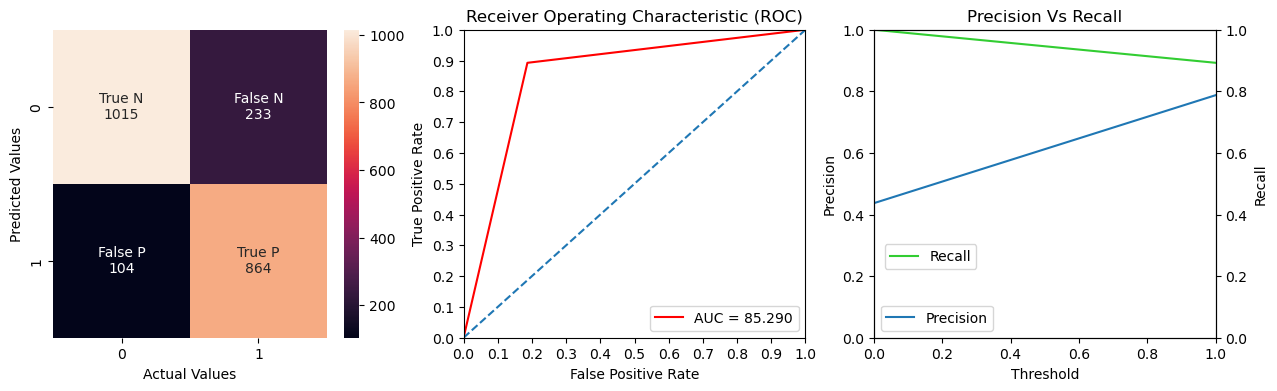

In [75]:
# ! pip install model-perf --upgrade
# import model_perf

# Dataframe to store Model Performance Results
perf_cols = ['Model','Train Accuracy','Test Accuracy','F1-Score','Recall','Precision', 'AUC']
df_perf = pd.DataFrame(columns = perf_cols)

# DataFrame for Confusion matrix
conf_mat_cols = ['Model','False Negatives','False Positives','True Negatives','True Positives']
df_cm = pd.DataFrame(columns = conf_mat_cols)

# DataFrame for cross validation scores
cv_cols = ['Model','Best_Cross_Val_Score']
df_cv = pd.DataFrame(columns = cv_cols)

#Draw Model Performace, Confusion Matrix and Classification Report
df_cm, df_perf = model_perf(churn_tree_pruned, Y_test, predictions, "Classification Tree", df_cm, df_perf, plot = True)